### Module 1: Data Analysis of Traffic Sign Dataset

> Processing all data into dataframe

In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import cv2
import seaborn as sns
df = pd.DataFrame(columns=['File','CLASS','X','Y','WIDTH','HEIGHT'])

In [41]:
#putting annotation data into dataframe
def read_txt_files(directory):
    data = []
    for FILENAME in os.listdir(directory):
        if FILENAME.endswith(".txt"):
            with open(os.path.join(directory, FILENAME), 'r') as file:
                for line in file:
                    class_, x, y, width, height = line.split()
                    data.append({
                        "FILENAME": FILENAME,
                        "CLASS": class_,
                        "X": x,
                        "Y": y,
                        "WIDTH": width,
                        "HEIGHT": height
                    })
    return data

# Update this path 
directory_path = ''
data = read_txt_files(directory_path)

df = pd.DataFrame(data)
df['CLASS'] = pd.to_numeric(df['CLASS'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors = 'coerce')
df['WIDTH'] = pd.to_numeric(df['WIDTH'], errors='coerce')
df['HEIGHT'] = pd.to_numeric(df['HEIGHT'], errors = 'coerce')
df['FILENAME'] = df['FILENAME'].str.replace('.txt', '', regex=False)
df['SIZE'] = df['WIDTH'] * df['HEIGHT']

In [42]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def bright_blur(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = cv2.mean(gray)[0]
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    return brightness, blur

def process_image(index, row, directory_path):
    filename = row['FILENAME']
    image_path = os.path.join(directory_path, filename + '.jpg')
    
    if os.path.exists(image_path):
        brightness, blur = bright_blur(image_path)
    else:
        brightness, blur = None, None
    return index, brightness, blur

# Number of workers
num_workers = os.cpu_count()

df['BRIGHT'] = None
df['BLUR'] = None

#run concurrently
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    future_to_result = {executor.submit(process_image, index, row, directory_path): index for index, row in df.iterrows()}
    
    for future in as_completed(future_to_result):
        index = future_to_result[future]
        try:
            result_index, brightness, blur = future.result()
            df.at[result_index, 'BRIGHT'] = brightness
            df.at[result_index, 'BLUR'] = blur
        except Exception as exc:
            print(f'Generated an exception: {exc}')
            df.at[index, 'BRIGHT'] = None
            df.at[index, 'BLUR'] = None

> Plots

Text(0, 0.5, 'Frequency')

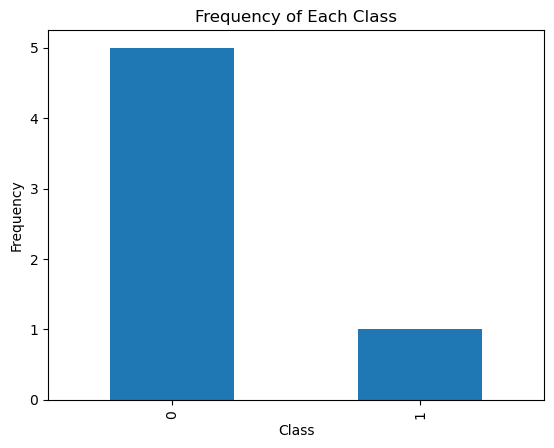

In [43]:
class_counts = df['CLASS'].value_counts()

ax = class_counts.plot(kind='bar')
ax.set_title('Frequency of Each Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')

> Size

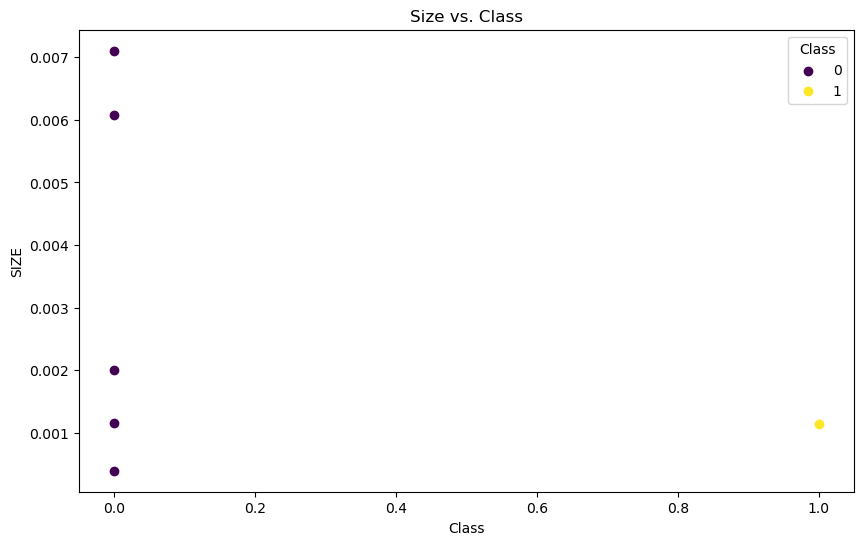

In [44]:
unique_classes = df['CLASS'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

class_color_mapping = {class_label: color for class_label, color in zip(unique_classes, colors)}
plt.figure(figsize=(10, 6))
ax = plt.gca()

for class_label, color in class_color_mapping.items():
    subset = df[df['CLASS'] == class_label]
    ax.scatter(subset['CLASS'], subset['SIZE'], label=class_label, color=color, alpha=1)

plt.xlabel("Class")
plt.ylabel("SIZE")
plt.title("Size vs. Class")

plt.legend(title="Class", loc='upper right')

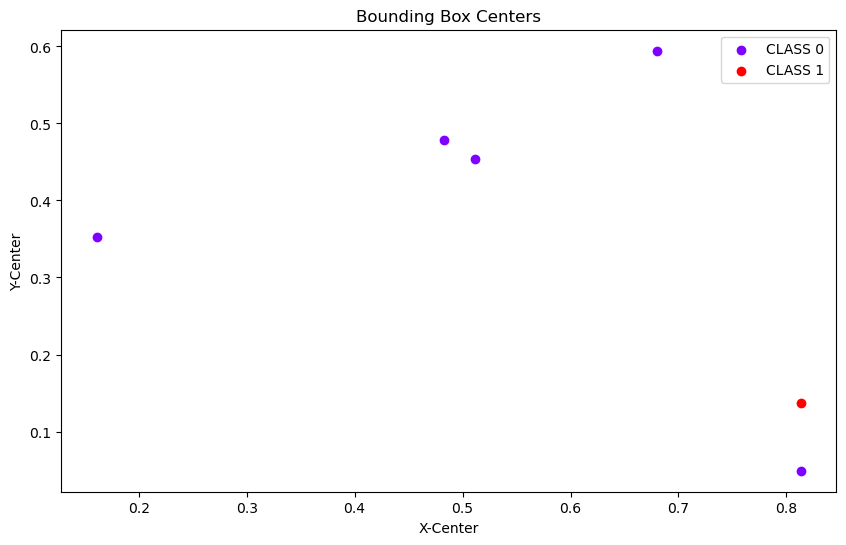

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
unique_classes = df['CLASS'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
class_color_map = dict(zip(unique_classes, colors))

for cls in unique_classes:
    class_subset = df[df['CLASS'] == cls]
    ax.scatter(class_subset['X'], class_subset['Y'], color=class_color_map[cls], label=f'CLASS {cls}')
    
ax.set_title('Bounding Box Centers')
ax.set_xlabel('X-Center')
ax.set_ylabel('Y-Center')
ax.legend()

> Brightness

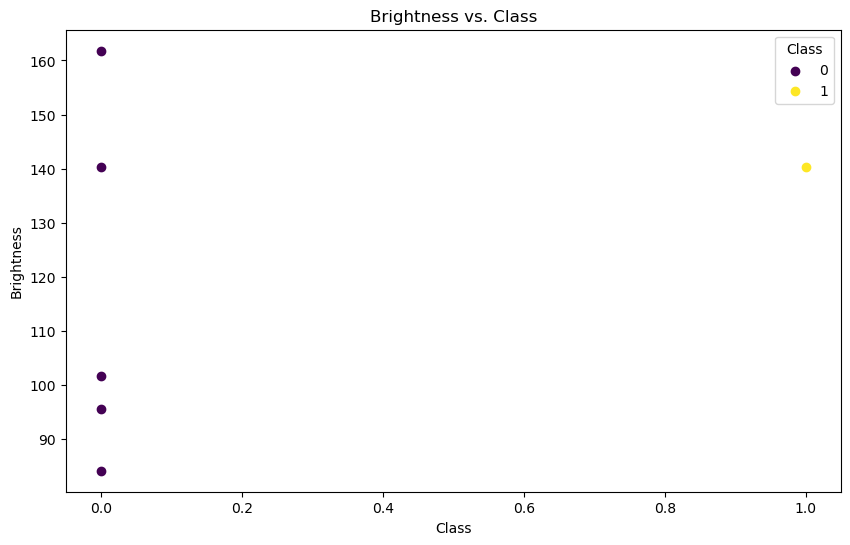

In [46]:
unique_classes = df['CLASS'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

class_color_mapping = {class_label: color for class_label, color in zip(unique_classes, colors)}
plt.figure(figsize=(10, 6))
ax = plt.gca()

for class_label, color in class_color_mapping.items():
    subset = df[df['CLASS'] == class_label]
    ax.scatter(subset['CLASS'], subset['BRIGHT'], label=class_label, color=color, alpha=1)

plt.xlabel("Class")
plt.ylabel("Brightness")
plt.title("Brightness vs. Class")

plt.legend(title="Class", loc='upper right')

> Blur

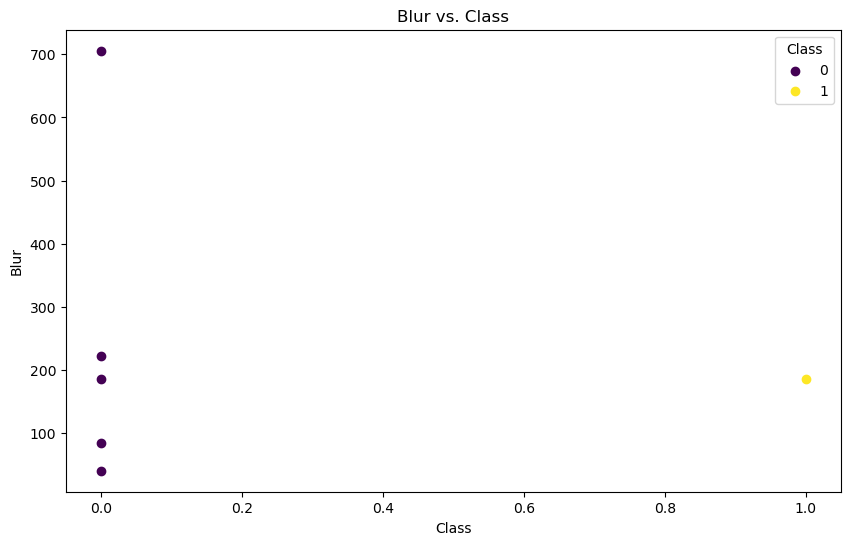

In [47]:
unique_classes = df['CLASS'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

class_color_mapping = {class_label: color for class_label, color in zip(unique_classes, colors)}
plt.figure(figsize=(10, 6))
ax = plt.gca()

for class_label, color in class_color_mapping.items():
    subset = df[df['CLASS'] == class_label]
    ax.scatter(subset['CLASS'], subset['BLUR'], label=class_label, color=color, alpha=1)

plt.xlabel("Class")
plt.ylabel("Blur")
plt.title("Blur vs. Class")

plt.legend(title="Class", loc='upper right')

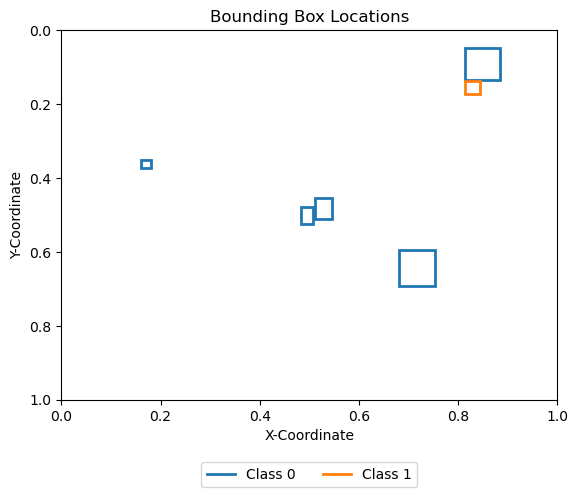

In [48]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
unique_classes = np.unique(df['CLASS'])
legend_handles = []

for class_value in unique_classes:
    color = cmap(class_value % 10)  # Use modulo to wrap colors if there are more than 10 classes
    legend_line = plt.Line2D([0], [0], color=color, lw=2, label=f'Class {class_value}')
    legend_handles.append(legend_line)

for index, row in df.iterrows():
    x, y, width, height, class_value = row['X'], row['Y'], row['WIDTH'], row['HEIGHT'], row['CLASS']
    color = cmap(class_value % 10)  # Use modulo to wrap colors if there are more than 10 classes
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

ax.set_title('Bounding Box Locations')
ax.set_xlabel('X-Coordinate')
ax.set_ylabel('Y-Coordinate')

ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(unique_classes))
plt.gca().invert_yaxis()  # Invert the Y-axis to match common rectangle coordinates
# plt.show()

> Overlaid images

In [49]:
import seaborn as sns
from PIL import Image

In [50]:
#creating separate dataframes for each class
df_class0 = df[df['CLASS'] == 0]
df_class1 = df[df['CLASS'] == 1]
df_class2 = df[df['CLASS'] == 2]

In [51]:
#Function crops the image and saves in new folder based on class
def crop_image(df, image_dir, save_dir):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for index, row in df.iterrows():
        # Construct the full image path
        image_path = os.path.join(image_dir, row['FILENAME'] + '.jpg')
        
        # Open the image
        try:
            with Image.open(image_path) as img:
                # Image dimensions
                img_width, img_height = img.size
                
                # Calculate the crop box
                left = (row['X'] - row['WIDTH'] / 2) * img_width
                upper = (row['Y'] - row['HEIGHT'] / 2) * img_height
                right = (row['X'] + row['WIDTH'] / 2) * img_width
                lower = (row['Y'] + row['HEIGHT'] / 2) * img_height
                
                # Crop the image
                img_cropped = img.crop((left, upper, right, lower))
                
                # Save the cropped image
                img_cropped.save(os.path.join(save_dir, row['FILENAME'] + '_cropped.jpg'))
        except FileNotFoundError:
            print(f"File not found: {image_path}")
        except Exception as e:
            print(f"Error processing file {image_path}: {e}")

# Directories
image_dir = ''
save_dir0 = ''
save_dir1 = ''
save_dir2 = ''

# Call the function for each class
crop_image(df_class0, image_dir, save_dir0)
crop_image(df_class1, image_dir, save_dir1)
crop_image(df_class2, image_dir, save_dir2)

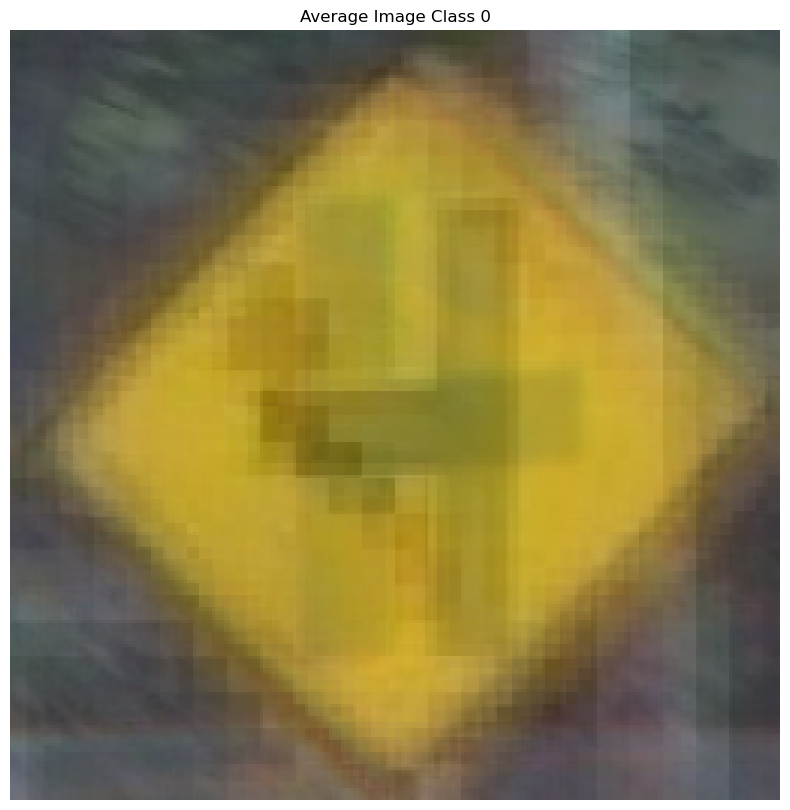

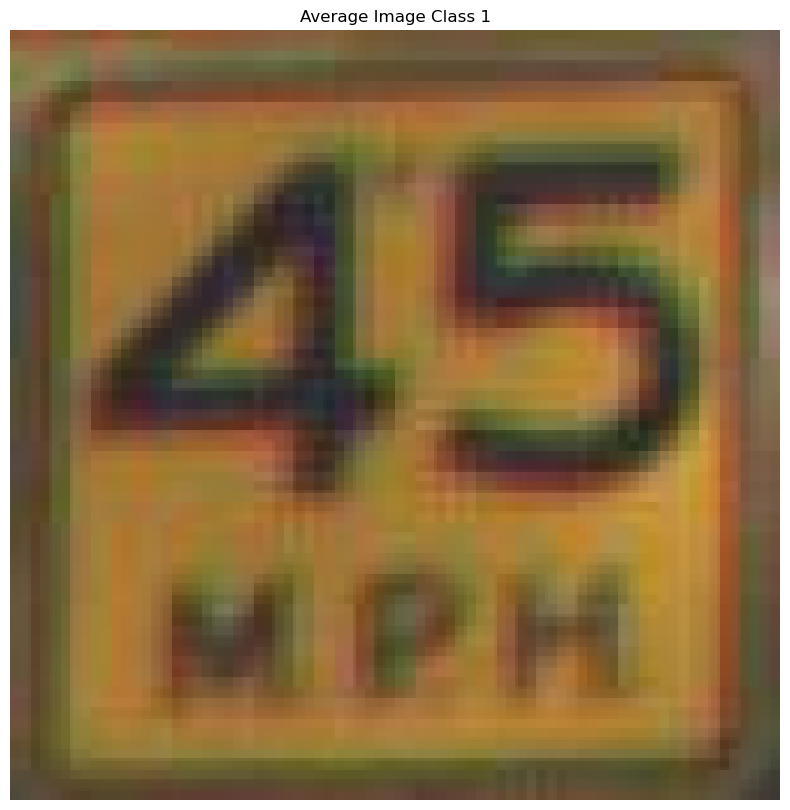

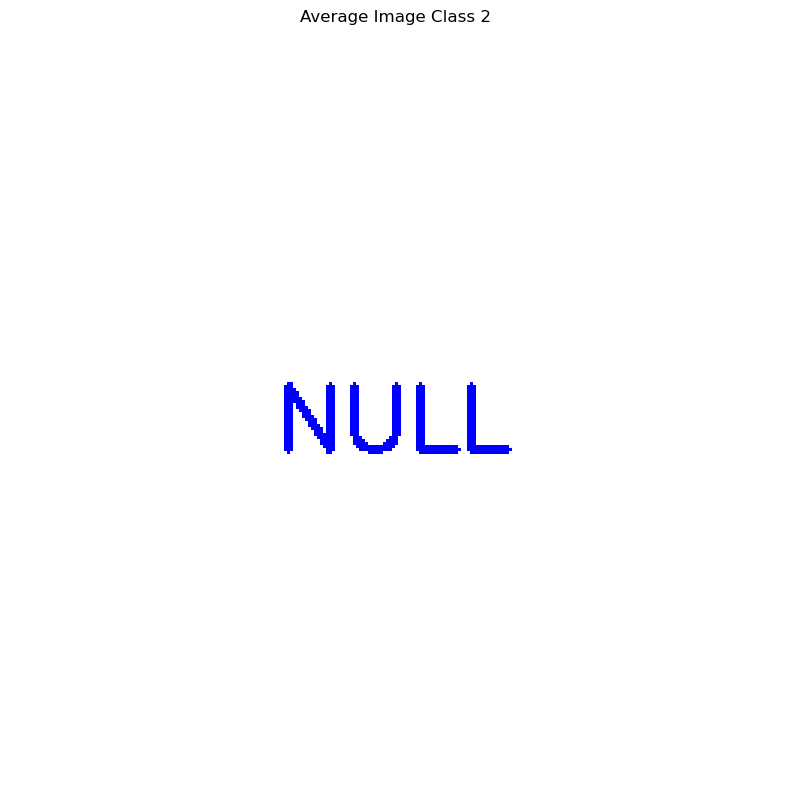

In [52]:
#function overlays images based on previously created cropped images
def avg_img(image_dir, class_name, target_size=(256, 256)):
    # Create 'image class average' directory if it doesn't exist
    output_dir = os.path.join('', 'Average Image')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    resized_images = []
    
    # Process each image in the directory
    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".jpg", ".png")):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            if image is not None:
                resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
                resized_images.append(resized)
    
    if len(resized_images) > 0:
        # Calculate average image
        average_image = np.mean(resized_images, axis=0).astype(np.uint8)
        # Convert BGR to RGB for matplotlib
        average_image_rgb = cv2.cvtColor(average_image, cv2.COLOR_BGR2RGB)
    else:
        # Create a blank white image
        average_image_rgb = np.full((target_size[1], target_size[0], 3), 255, dtype=np.uint8)
        text = "NULL"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        textSize = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        # Get the text start position to center the text
        textX = (average_image_rgb.shape[1] - textSize[0]) // 2
        textY = (average_image_rgb.shape[0] + textSize[1]) // 2
        # Put the text on the white image
        cv2.putText(average_image_rgb, text, (textX, textY), font, font_scale, (0, 0, 255), font_thickness)
    
    # Display the average image
    plt.figure(figsize=(10, 10))
    plt.imshow(average_image_rgb)
    plt.title(f'Average Image {class_name}')
    plt.axis('off')  # Hide axes
    plt.show()
    
    # Save the average image
    save_path = os.path.join(output_dir, f'average_image_{class_name}.jpg')
    if len(resized_images) > 0:
        # Save the BGR image for OpenCV compatibility
        cv2.imwrite(save_path, cv2.cvtColor(average_image_rgb, cv2.COLOR_RGB2BGR))
    else:
        # Save the white image with centered text
        cv2.imwrite(save_path, average_image_rgb)

avg_img(save_dir0, "Class 0")
avg_img(save_dir1, "Class 1")
avg_img(save_dir2, "Class 2")